In [19]:
import Traitement_de_texte as tt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from Traitement_de_texte import preprocess_text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, classification_report, f1_score, accuracy_score ,roc_curve
import dill
import logging
from yellowbrick.classifier import DiscriminationThreshold

from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay,
                             roc_auc_score,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             RocCurveDisplay,
                             PrecisionRecallDisplay,
                            )


In [2]:
chemin = r'C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models\train_test_split.dill'
with open(chemin, 'rb') as f:
    x_train, x_test, y_train, y_test = dill.load(f)

In [7]:
# Configurer le logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

### Feature engineering

In [3]:
# Préprocesseur de texte avec lemmatisation et TF-IDF
text_preprocessor = Pipeline(steps=[
    ('lemmatizer', FunctionTransformer(preprocess_text)),  # Nettoyage de texte ...
    ('tfidf', TfidfVectorizer(max_features=6000))  # TF-IDF vectorisation
])

# Application du préprocesseur à la colonne 'text'
preprocessor = ColumnTransformer(transformers=[
    ('text', text_preprocessor, 'text')  # Appliquer le préprocesseur uniquement à la colonne 'text'
])

preprocessor


ColumnTransformer(transformers=[('text',
                                 Pipeline(steps=[('lemmatizer',
                                                  FunctionTransformer(func=<function preprocess_text at 0x0000017363D69580>)),
                                                 ('tfidf',
                                                  TfidfVectorizer(max_features=6000))]),
                                 'text')])

In [49]:
# Pipeline 
text_preprocessor = Pipeline(steps=[
    ('lemmatizer', FunctionTransformer(preprocess_text)),  # Fonction personnalisée
    ('tfidf', TfidfVectorizer(max_features=6000))
])

# Pipeline pour has_geo (pas de transformation ici, juste un passage direct)
geo_preprocessor = 'passthrough'  

# ColumnTransformer global
preprocessor = ColumnTransformer(transformers=[
    ('text', text_preprocessor, 'text'),        # Pipeline texte principal
    ('keyword', text_preprocessor, 'keyword'),  # Applique le même traitement que pour 'text'
    ('has_geo', geo_preprocessor, ['has_geo'])  # Variable binaire géographique
])

preprocessor

ColumnTransformer(transformers=[('text',
                                 Pipeline(steps=[('lemmatizer',
                                                  FunctionTransformer(func=<function preprocess_text at 0x0000017363D69580>)),
                                                 ('tfidf',
                                                  TfidfVectorizer(max_features=6000))]),
                                 'text'),
                                ('keyword',
                                 Pipeline(steps=[('lemmatizer',
                                                  FunctionTransformer(func=<function preprocess_text at 0x0000017363D69580>)),
                                                 ('tfidf',
                                                  TfidfVectorizer(max_features=6000))]),
                                 'keyword'),
                                ('has_geo', 'passthrough', ['has_geo'])])

In [50]:
MODEL_DIR = r'C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models'
preprocessor_path_name = Path(MODEL_DIR, "preprocessor.dill")

# Sauvegarder le modèle et le seuil
logger.info(f"preprocessor path name: {preprocessor_path_name}")
with open(preprocessor_path_name, "wb") as fp:
    dill.dump(preprocessor, fp)


INFO:__main__:preprocessor path name: C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models\preprocessor.dill


### Random  Forest

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Ton préprocesseur (ex. : TF-IDF, encodage, etc.)
    ('clf', RandomForestClassifier(random_state=42))
])

rf_pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('lemmatizer',
                                                                   FunctionTransformer(func=<function preprocess_text at 0x0000017363D69580>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=6000))]),
                                                  'text'),
                                                 ('keyword',
                                                  Pipeline(steps=[('lemmatizer',
                                                                   FunctionTransformer(func=<function preprocess_text at 0x0000017363D69580>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=6000))]),
                                                  'keyword'),
                                                 ('has_geo', 'passthrough',
                                                  ['has_geo'])])),
                ('clf', RandomForestClassifier(random_state=42))])

#### Baseline

In [8]:
# Training
rf_pipeline.fit(x_train, y_train)

# Predictions & evaluation
rf_y_pred_test = rf_pipeline.predict(x_test)
rf_y_proba_test = rf_pipeline.predict_proba(x_test)[:, 1]

logger.info(f"AUC: {roc_auc_score(y_test, rf_y_proba_test):.2f}")
logger.info(f"Classification report: \n{classification_report(y_test, rf_y_pred_test)}")


INFO:__main__:AUC: 0.90
INFO:__main__:Classification report: 
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1851
           1       0.82      0.40      0.54       423

    accuracy                           0.87      2274
   macro avg       0.85      0.69      0.73      2274
weighted avg       0.87      0.87      0.85      2274



##### Tuning hyperparameters

In [14]:
rf_param_grid = {
    'clf__n_estimators': [100, 150],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5, 10]
}

In [15]:
# Cross-validation
cv = StratifiedKFold(n_splits=5)

# GridSearchCV
rf_grid_search = GridSearchCV(
    rf_pipeline, 
    rf_param_grid, 
    cv=cv, 
    scoring='roc_auc', 
    n_jobs=-1, 
    verbose=2
)

# Entraînement
rf_grid_search.fit(x_train, y_train)

# Meilleurs hyperparamètres
logger.info(f"Best params : {rf_grid_search.best_params_}")

# Prédictions sur le jeu de test
rf_y_pred_test_opt = rf_grid_search.predict(x_test)
rf_y_proba_test_opt = rf_grid_search.predict_proba(x_test)[:, 1]

# Évaluation finale
logger.info(f"AUC : {roc_auc_score(y_test, rf_y_proba_test_opt):.2f}")
logger.info(f"F1-score : {f1_score(y_test, rf_y_pred_test_opt):.2f}")
logger.info(f"Accuracy : {accuracy_score(y_test, rf_y_pred_test_opt):.2f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits


INFO:__main__:Best params : {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 150}
INFO:__main__:AUC : 0.90
INFO:__main__:F1-score : 0.54
INFO:__main__:Accuracy : 0.87


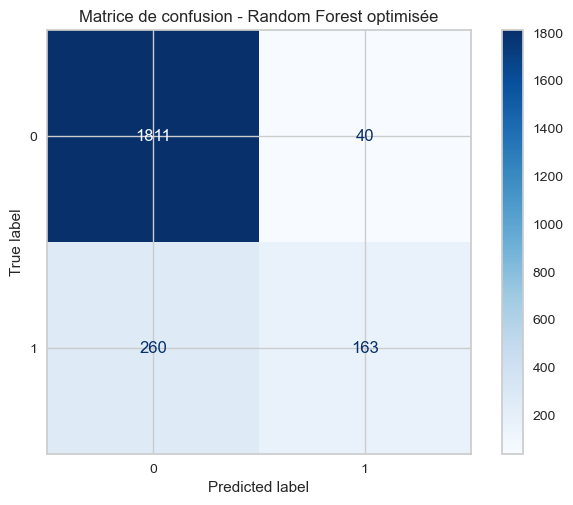

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Récupération du meilleur modèle entraîné
rf_best_model = rf_grid_search.best_estimator_

# Récupération des classes
class_names = rf_best_model.named_steps['clf'].classes_

# Affichage de la matrice de confusion
ConfusionMatrixDisplay.from_estimator(
    rf_best_model, x_test, y_test,
    display_labels=class_names,
    normalize=None,  # Tu peux aussi mettre 'true' pour taux de bonne prédiction
    cmap=plt.cm.Blues
)
plt.title("Matrice de confusion - Random Forest optimisée")
plt.show()


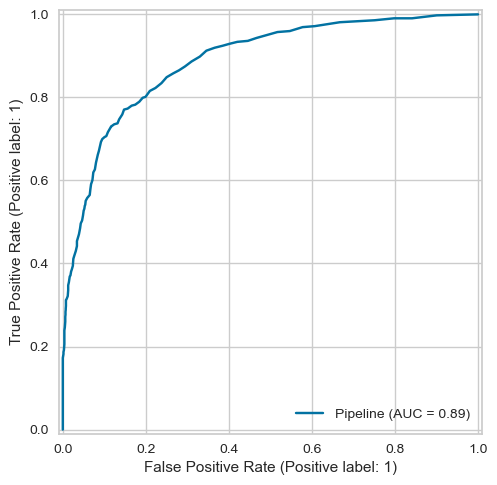

In [46]:
RocCurveDisplay.from_estimator(rf_grid_search.best_estimator_, x_test, y_test)

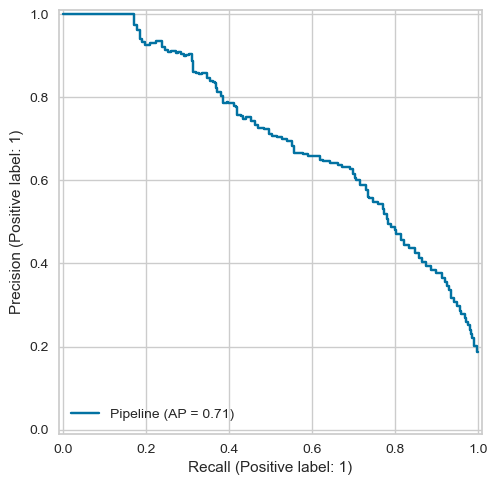

In [47]:
PrecisionRecallDisplay.from_estimator(rf_grid_search.best_estimator_, x_test, y_test);

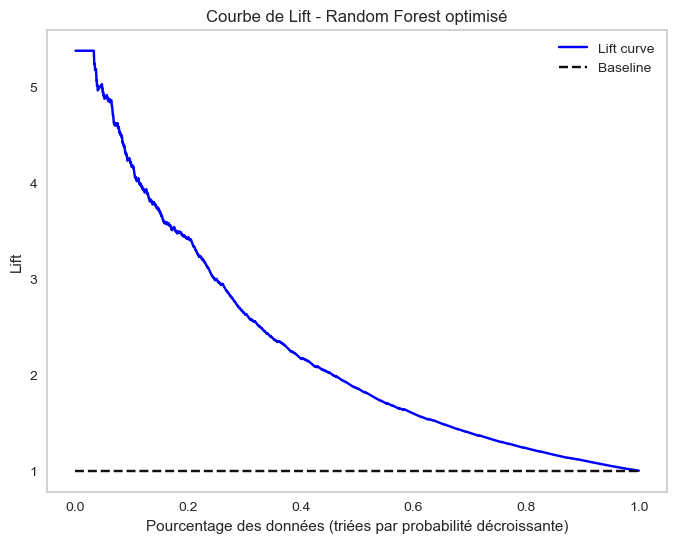

In [48]:
# 1. Prédire les probabilités avec le meilleur modèle Random Forest
y_pred_proba = rf_grid_search.best_estimator_.predict_proba(x_test)[:, 1]

# 2. Trier les résultats par score décroissant
sorted_indices = np.argsort(y_pred_proba)[::-1]
y_test_sorted = y_test.values[sorted_indices]
y_pred_sorted = y_pred_proba[sorted_indices]

# 3. Calculer le lift
n_samples = len(y_test)
cumulative_y_true = np.cumsum(y_test_sorted)
perc_samples = np.arange(1, n_samples + 1) / n_samples
lift = cumulative_y_true / (perc_samples * cumulative_y_true[-1])

# 4. Tracer la courbe de lift
plt.figure(figsize=(8, 6))
plt.plot(perc_samples, lift, label='Lift curve', color='blue')
plt.plot([0, 1], [1, 1], 'k--', label='Baseline')
plt.xlabel('Pourcentage des données (triées par probabilité décroissante)')
plt.ylabel('Lift')
plt.title('Courbe de Lift - Random Forest optimisé')
plt.legend()
plt.grid()
plt.show()


#### Ajustement du seuil

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, classification_report
import numpy as np

# 1. Séparation du jeu d'entraînement en train / validation
x_train_new, x_val, y_train_new, y_val = train_test_split(
    x_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# 2. Récupération du meilleur modèle RF après GridSearch
rl_best_model = rf_grid_search.best_estimator_

# 3. Prédictions des probabilités sur le jeu de validation
val_proba = rl_best_model.predict_proba(x_val)[:, 1]

# 4. Calcul du F1-score pour différents seuils
f1_scores = []
thresholds = np.linspace(0, 1, 101)

for threshold in thresholds:
    y_pred = (val_proba >= threshold).astype(int)
    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)

# 5. Trouver le seuil qui maximise le F1-score
optimal_f1_threshold = thresholds[np.argmax(f1_scores)]
logger.info(f"Seuil optimal (F1-score, validation) : {optimal_f1_threshold:.4f}")

# 6. Évaluation finale sur le jeu de test avec ce seuil optimal
test_proba = rl_best_model.predict_proba(x_test)[:, 1]
test_pred_opt_f1 = (test_proba >= optimal_f1_threshold).astype(int)

# 7. Affichage des résultats
logger.info(f"AUC sur le jeu de test : {roc_auc_score(y_test, test_proba):.2f}")
logger.info(f"Rapport de classification (seuil optimal) :\n{classification_report(y_test, test_pred_opt_f1)}")


INFO:__main__:Seuil optimal (F1-score, validation) : 0.5200
INFO:__main__:AUC sur le jeu de test : 0.90
INFO:__main__:Rapport de classification (seuil optimal) :
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1851
           1       0.84      0.39      0.54       423

    accuracy                           0.87      2274
   macro avg       0.86      0.69      0.73      2274
weighted avg       0.87      0.87      0.85      2274



#### Sauvegarde du model

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, classification_report
import numpy as np

# 1. Séparation en train / validation
x_train_new, x_val, y_train_new, y_val = train_test_split(
    x_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# 2. Utiliser le meilleur modèle Random Forest après GridSearch
rf_best_model = rf_grid_search.best_estimator_

# 3. Prédictions sur le jeu de validation
val_proba = rf_best_model.predict_proba(x_val)[:, 1]

# 4. Liste pour stocker les F1-scores pour différents seuils
f1_scores = []
thresholds = np.linspace(0, 1, 101)

for threshold in thresholds:
    y_pred = (val_proba >= threshold).astype(int)
    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)

# 5. Seuil qui maximise le F1-score
optimal_f1_threshold = thresholds[np.argmax(f1_scores)]
logger.info(f"Seuil optimal (F1-score, valid set) : {optimal_f1_threshold:.4f}")

# 6. Évaluation finale sur le jeu de test avec ce seuil
test_proba = rf_best_model.predict_proba(x_test)[:, 1]
test_pred_opt_f1 = (test_proba >= optimal_f1_threshold).astype(int)

# 7. Affichage des résultats
logger.info(f"AUC test : {roc_auc_score(y_test, test_proba):.2f}")
logger.info(f"Classification report (seuil optimal sur test) :\n{classification_report(y_test, test_pred_opt_f1)}")


INFO:__main__:Seuil optimal (F1-score, valid set) : 0.5200
INFO:__main__:AUC test : 0.90
INFO:__main__:Classification report (seuil optimal sur test) :
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1851
           1       0.84      0.39      0.54       423

    accuracy                           0.87      2274
   macro avg       0.86      0.69      0.73      2274
weighted avg       0.87      0.87      0.85      2274



In [ ]:
# seuil optimal 0.5200

#### Sauvegarde du model

In [27]:
class RlBestModelOptimized:
    def __init__(self, model, threshold):
        self.model = model
        self.threshold = threshold

    def predict(self, X):
        proba = self.model.predict_proba(X)[:, 1]
        return (proba >= self.threshold).astype(int)

    def predict_proba(self, X):
        return self.model.predict_proba(X)


In [28]:
from pathlib import Path
import dill

# Définir le répertoire et le nom du fichier
MODEL_DIR = r'C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models'
model_path_name = Path(MODEL_DIR, "rf_best_model_optimized.dill")

# Créer l'objet avec le modèle Random Forest et son seuil optimal
rf_best_model_optimized = RlBestModelOptimized(model=rf_best_model, threshold=optimal_f1_threshold)

# Sauvegarder le modèle et le seuil
logger.info(f"Model path name: {model_path_name}")
with open(model_path_name, "wb") as fp:
    dill.dump(rf_best_model_optimized, fp)

logger.info(f"Random Forest model with optimal threshold saved at: {model_path_name}")


INFO:__main__:Model path name: C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models\rf_best_model_optimized.dill
INFO:__main__:Random Forest model with optimal threshold saved at: C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models\rf_best_model_optimized.dill


### XGBOOST

In [33]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Pipeline avec XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Ton préprocesseur (TF-IDF, OneHotEncoder, etc.)
    ('clf', XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='auc',
        random_state=42
    ))
])

xgb_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('lemmatizer',
                                                                   FunctionTransformer(func=<function preprocess_text at 0x0000017363D69580>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=6000))]),
                                                  'text'),
                                                 ('keyword',
                                                  Pipeline(steps=[('lemmatizer',
                                                                   FunctionTransformer(func=<function preprocess_text at 0x0000017363D69580>)),
                                                                  ('tfid...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

#### Baseline

In [34]:
# Training
xgb_pipeline.fit(x_train, y_train)

# Predictions & evaluation
xgb_y_pred_test = xgb_pipeline.predict(x_test)
xgb_y_proba_test = xgb_pipeline.predict_proba(x_test)[:, 1]

logger.info(f"AUC: {roc_auc_score(y_test, xgb_y_proba_test):.2f}")
logger.info(f"Classification report: \n{classification_report(y_test, xgb_y_pred_test)}")


C:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:56:08] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
INFO:__main__:AUC: 0.87
INFO:__main__:Classification report: 
              precision    recall  f1-score   support

           0       0.88      0.98      0.92      1851
           1       0.80      0.41      0.54       423

    accuracy                           0.87      2274
   macro avg       0.84      0.69      0.73      2274
weighted avg       0.86      0.87      0.85      2274



##### Tuning hyperparameters

In [37]:
xgb_param_grid = {
    'clf__n_estimators': [100, 150],           # nombre d’arbres (suffisant pour commencer)
    'clf__max_depth': [3, 6],                  # complexité de l'arbre (3 = simple, 6 = plus profond)
    'clf__learning_rate': [0.05, 0.1],         # taux d’apprentissage modéré
    'clf__subsample': [0.8],                   # échantillonnage des lignes (évite surapprentissage)
    'clf__colsample_bytree': [0.8, 1.0]        # échantillonnage des colonnes (stabilité du modèle)
}


In [39]:
# Cross-validation
cv = StratifiedKFold(n_splits=5)

# GridSearchCV pour XGBoost
xgb_grid_search = GridSearchCV(
    xgb_pipeline, 
    xgb_param_grid, 
    cv=cv, 
    scoring='roc_auc', 
    n_jobs=-1, 
    verbose=2
)

# Entraînement
xgb_grid_search.fit(x_train, y_train)

# Meilleurs hyperparamètres
logger.info(f"Best params : {xgb_grid_search.best_params_}")

# Prédictions sur le jeu de test
xgb_y_pred_test_opt = xgb_grid_search.predict(x_test)
xgb_y_proba_test_opt = xgb_grid_search.predict_proba(x_test)[:, 1]

# Évaluation finale
logger.info(f"AUC : {roc_auc_score(y_test, xgb_y_proba_test_opt):.2f}")
logger.info(f"F1-score : {f1_score(y_test, xgb_y_pred_test_opt):.2f}")
logger.info(f"Accuracy : {accuracy_score(y_test, xgb_y_pred_test_opt):.2f}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:12:07] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
INFO:__main__:Best params : {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 150, 'clf__subsample': 0.8}
INFO:__main__:AUC : 0.87
INFO:__main__:F1-score : 0.48
INFO:__main__:Accuracy : 0.86


#### Ajustement du seuil

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, classification_report
import numpy as np

# 1. Séparation du jeu d'entraînement en train / validation
x_train_new, x_val, y_train_new, y_val = train_test_split(
    x_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# 2. Récupération du meilleur modèle RF après GridSearch
xgb_best_model = xgb_grid_search.best_estimator_

# 3. Prédictions des probabilités sur le jeu de validation
val_proba = xgb_best_model.predict_proba(x_val)[:, 1]

# 4. Calcul du F1-score pour différents seuils
f1_scores = []
thresholds = np.linspace(0, 1, 101)

for threshold in thresholds:
    y_pred = (val_proba >= threshold).astype(int)
    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)

# 5. Trouver le seuil qui maximise le F1-score
optimal_f1_threshold = thresholds[np.argmax(f1_scores)]
logger.info(f"Seuil optimal (F1-score, validation) : {optimal_f1_threshold:.4f}")

# 6. Évaluation finale sur le jeu de test avec ce seuil optimal
test_proba = rl_best_model.predict_proba(x_test)[:, 1]
test_pred_opt_f1 = (test_proba >= optimal_f1_threshold).astype(int)

# 7. Affichage des résultats
logger.info(f"AUC sur le jeu de test : {roc_auc_score(y_test, test_proba):.2f}")
logger.info(f"Rapport de classification (seuil optimal) :\n{classification_report(y_test, test_pred_opt_f1)}")


INFO:__main__:Seuil optimal (F1-score, validation) : 0.2600
INFO:__main__:AUC sur le jeu de test : 0.89
INFO:__main__:Rapport de classification (seuil optimal) :
              precision    recall  f1-score   support

           0       0.94      0.88      0.90      1851
           1       0.58      0.74      0.65       423

    accuracy                           0.85      2274
   macro avg       0.76      0.81      0.78      2274
weighted avg       0.87      0.85      0.86      2274



In [ ]:
# seuil optimal 0.26

#### Sauvegarde du model

In [41]:
class XgbBestModelOptimized:
    def __init__(self, model, threshold):
        self.model = model
        self.threshold = threshold

    def predict(self, X):
        proba = self.model.predict_proba(X)[:, 1]
        return (proba >= self.threshold).astype(int)

    def predict_proba(self, X):
        return self.model.predict_proba(X)


In [43]:
from pathlib import Path
import dill

# Définir le répertoire et le nom du fichier
MODEL_DIR = r'C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models'
model_path_name = Path(MODEL_DIR, "xgb_best_model_optimized.dill")

# Créer l'objet avec le modèle XGBoost et son seuil optimal
xgb_best_model_optimized = XgbBestModelOptimized(model=xgb_best_model, threshold=optimal_f1_threshold)

# Sauvegarder le modèle et le seuil
logger.info(f"Model path name: {model_path_name}")
with open(model_path_name, "wb") as fp:
    dill.dump(xgb_best_model_optimized, fp)

logger.info(f"XGBoost model with optimal threshold saved at: {model_path_name}")


INFO:__main__:Model path name: C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models\xgb_best_model_optimized.dill
INFO:__main__:XGBoost model with optimal threshold saved at: C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models\xgb_best_model_optimized.dill
